In [14]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from random import randint
from re import sub
from decimal import Decimal
import numpy as np
from datetime import datetime
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t


# Web Scrapping

In [117]:
car_info = []

for value in range(0,177*100,100):

    url = f"https://www.sgcarmart.com/used_cars/listing.php?BRSR={value}&RPG=100&AVL=2&VEH=0"

    res = requests.get(url)

    soup = BeautifulSoup(res.content, "html.parser")

    listing_name_info = soup.find_all("div", attrs={'style': "width:186px;padding-left:4px;"})
    price_info = soup.find_all("div", attrs={"style":"width:67px; font-weight:bold;"})
    depreciation_info = soup.find_all("div", attrs={"style":"width:101px;"})
    reg_date_info = soup.find_all("div", attrs={"style":"width:89px;"})
    eng_cap_info = soup.find_all("div", attrs={"style":"width:84px;"})
    mileage_info = soup.find_all("div", attrs={"style":"width:83px;"})
    veh_type_info = soup.find_all("div", attrs={"style":"width:89px;"})

    for i in range(0,len(listing_name_info)):
        listing_name = listing_name_info[i].find_all("a")[0].text.strip()
        price = price_info[i].text.strip()
        depreciation = depreciation_info[i].text.strip()
        reg_date = reg_date_info[i*2].text.strip()
        eng_cap = eng_cap_info[i].text.strip()
        mileage = mileage_info[i].text.strip()
        veh_type = veh_type_info[(i*2)+1].text.strip()

        row = {
            "listing_name": listing_name,
            "price": price,
            "depreciation": depreciation,
            "reg_date": reg_date,
            "eng_cap": eng_cap,
            "mileage": mileage,
            "veh_type": veh_type
        }

        car_info.append(row)
    time.sleep(randint(1,15))

car_info_df = pd.DataFrame(car_info)

car_info_df.to_csv('sgcarmart_listings_3Sep2022.csv')

# Data Cleaning

In [15]:
car_info_df_clean = pd.read_csv("sgcarmart_listings_3Sep2022.csv")
print(len(car_info_df_clean.index))

#drop rows with "-" in the price column
car_info_df_clean_drop = car_info_df_clean[car_info_df_clean["price"] != "-"]
car_info_df_clean_drop = car_info_df_clean_drop.replace("-", np.NaN)
car_info_df_clean_drop = car_info_df_clean_drop.replace('N.A',np.NaN)
car_info_df_clean_drop = car_info_df_clean_drop.replace('N.A.',np.NaN)


#rows drop from 17625 to 17595
print(len(car_info_df_clean_drop.index))

#split listing name into brand and model
car_info_df_clean_drop[['brand', 'model']] = car_info_df_clean_drop['listing_name'].str.split(' ', n=1, expand=True)

#transform price from str to float
car_info_df_clean_drop['price'] =  car_info_df_clean_drop['price'].replace('[\$,]', '', regex=True).astype(float)

#transfrom depreciation per year to float
car_info_df_clean_drop['depreciation'] = car_info_df_clean_drop['depreciation'].replace({" /yr": "", '[\$,]': ''}, regex=True).astype(float)

#transform reg_date column from str to datetime
car_info_df_clean_drop['reg_date'] =  pd.to_datetime(car_info_df_clean_drop['reg_date'], format="%d-%b-%Y")

#remove units from eng_cap and transfrom from str to datetime
car_info_df_clean_drop['eng_cap'] = car_info_df_clean_drop['eng_cap'].replace({" cc": "", ',': ''}, regex=True).astype(float)

#remove units from mileage and transfrom from str to datetime
car_info_df_clean_drop['mileage'] = car_info_df_clean_drop['mileage'].replace({" km": "", ',': ''}, regex=True).astype(float)

car_info_df_clean_drop.drop("Unnamed: 0", axis=1, inplace=True)

car_info_df_clean_drop.to_csv('sgcarmart_listings_3Sep2022_cleaned.csv')

17617
17587


# Visualisations

### Nicholas' Visualisations

In [16]:
data = pd.read_csv('sgcarmart_listings_3Sep2022_cleaned.csv')
data.head(6)

,Unnamed: 0,listing_name,price,depreciation,reg_date,eng_cap,mileage,veh_type,brand,model
0,0,Mercedes-Benz GLA-Class GLA200,50888.0,23370.0,2014-05-26,1595.0,123122.0,SUV,Mercedes-Benz,GLA-Class GLA200
1,1,Mercedes-Benz A-Class A180 Style,71800.0,17720.0,2016-03-07,1595.0,55000.0,Hatchback,Mercedes-Benz,A-Class A180 Style
2,2,Mazda 3 HB 1.5A Deluxe,84800.0,13510.0,2018-04-12,1496.0,44500.0,Hatchback,Mazda,3 HB 1.5A Deluxe
3,3,Honda Fit 1.3A GF,72800.0,12120.0,2018-06-22,1317.0,49700.0,Hatchback,Honda,Fit 1.3A GF
4,4,Honda Jazz 1.5A RS,52888.0,13520.0,2016-03-04,1498.0,102126.0,Hatchback,Honda,Jazz 1.5A RS
5,5,MINI One 1.5A 5DR,148800.0,15620.0,2021-07-30,1499.0,9800.0,Hatchback,MINI,One 1.5A 5DR


In [17]:
data.drop(columns='Unnamed: 0', inplace=True)
data

,listing_name,price,depreciation,reg_date,eng_cap,mileage,veh_type,brand,model
0,Mercedes-Benz GLA-Class GLA200,50888.0,23370.0,2014-05-26,1595.0,123122.0,SUV,Mercedes-Benz,GLA-Class GLA200
1,Mercedes-Benz A-Class A180 Style,71800.0,17720.0,2016-03-07,1595.0,55000.0,Hatchback,Mercedes-Benz,A-Class A180 Style
2,Mazda 3 HB 1.5A Deluxe,84800.0,13510.0,2018-04-12,1496.0,44500.0,Hatchback,Mazda,3 HB 1.5A Deluxe
3,Honda Fit 1.3A GF,72800.0,12120.0,2018-06-22,1317.0,49700.0,Hatchback,Honda,Fit 1.3A GF
4,Honda Jazz 1.5A RS,52888.0,13520.0,2016-03-04,1498.0,102126.0,Hatchback,Honda,Jazz 1.5A RS
...,...,...,...,...,...,...,...,...,...
17582,Maxus G10 2.0A,63988.0,7470.0,2021-03-30,1995.0,15.0,Van,Maxus,G10 2.0A
17583,Toyota Raize 1.0A G,131988.0,15000.0,2021-03-26,996.0,88.0,SUV,Toyota,Raize 1.0A G
17584,Mazda 5 2.0A Sunroof,53800.0,15300.0,2015-08-14,1998.0,113418.0,MPV,Mazda,5 2.0A Sunroof
17585,Mercedes-Benz S-Class S350L (COE till 03/2027),62800.0,13730.0,2007-04-04,3498.0,183000.0,Luxury,Mercedes-Benz,S-Class S350L (COE till 03/2027)


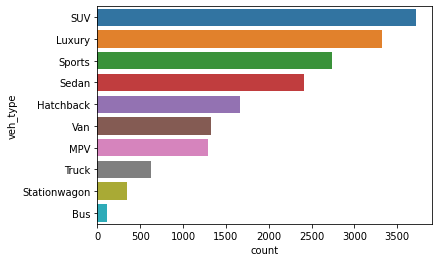

In [18]:
ax = sns.countplot(y="veh_type", data=data, order=data.veh_type.value_counts().iloc[:10].index)

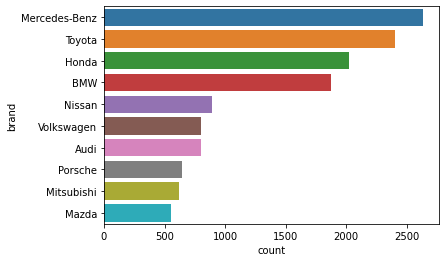

In [19]:
ax = sns.countplot(y="brand", data=data, order=data.brand.value_counts().iloc[:10].index)

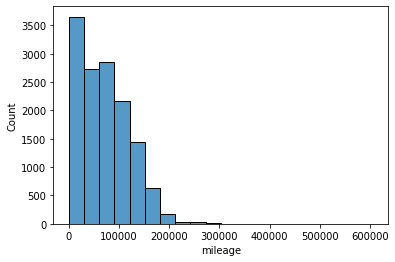

In [20]:
ax = sns.histplot(data = data, x = "mileage", bins = 20)

(0.0, 150000.0)

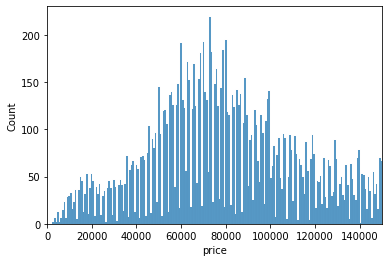

In [21]:
ax = sns.histplot(data = data, x = "price", bins = 5000)
ax.set_xlim(0,150000)

In [22]:
# 95% Confidence Interval

m = data["price"].mean() 
s = data["price"].std() 
dof = len(data["price"])-1 
confidence = 0.95

In [23]:
t_crit = np.abs(t.ppf((1-confidence)/2,dof))

In [24]:
(m-s*t_crit/np.sqrt(len(data["price"])), m+s*t_crit/np.sqrt(len(data["price"]))) 

(132969.82241592294, 137908.81191625423)

### Andrew's Visualisations

In [25]:
df = pd.read_csv('sgcarmart_listings_3Sep2022_cleaned.csv')
df.head()

,Unnamed: 0,listing_name,price,depreciation,reg_date,eng_cap,mileage,veh_type,brand,model
0,0,Mercedes-Benz GLA-Class GLA200,50888.0,23370.0,2014-05-26,1595.0,123122.0,SUV,Mercedes-Benz,GLA-Class GLA200
1,1,Mercedes-Benz A-Class A180 Style,71800.0,17720.0,2016-03-07,1595.0,55000.0,Hatchback,Mercedes-Benz,A-Class A180 Style
2,2,Mazda 3 HB 1.5A Deluxe,84800.0,13510.0,2018-04-12,1496.0,44500.0,Hatchback,Mazda,3 HB 1.5A Deluxe
3,3,Honda Fit 1.3A GF,72800.0,12120.0,2018-06-22,1317.0,49700.0,Hatchback,Honda,Fit 1.3A GF
4,4,Honda Jazz 1.5A RS,52888.0,13520.0,2016-03-04,1498.0,102126.0,Hatchback,Honda,Jazz 1.5A RS


In [26]:
df["veh_type"].unique()

array(['SUV', 'Hatchback', 'Sedan', 'Luxury', 'MPV', 'Van', 'Truck',
       'Sports', 'Stationwagon', 'Bus', 'Others'], dtype=object)

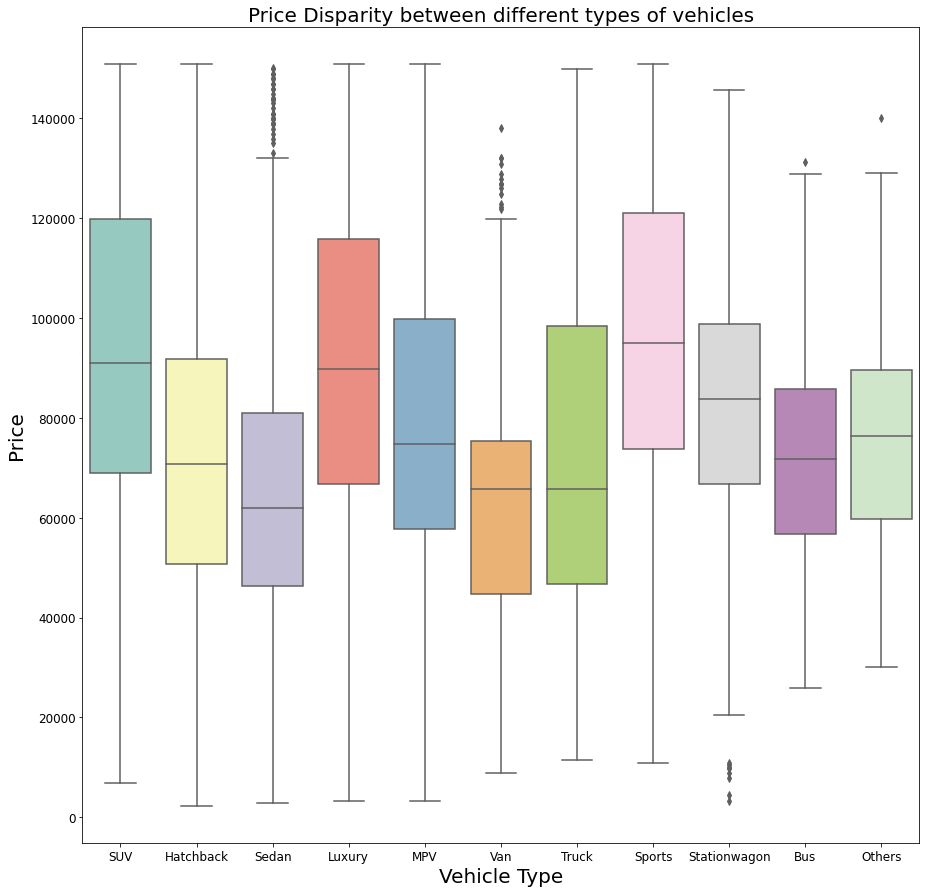

In [27]:
# 1. Relationship between vehicle type and price
# Draw insights into which vehicle types are more valued in the used car market
p = np.percentile(df["price"], 75)
df2 = df[df['price'] <= p] # Remove 75th percentile and above and easier visualisation, treat them as anomolies

plt.figure(figsize=(15,15))
ax = sns.boxplot(data=df2, x="veh_type", y="price", palette="Set3")
ax.axes.set_title("Price Disparity between different types of vehicles", fontsize=20)
ax.set_xlabel("Vehicle Type", fontsize=20)
ax.set_ylabel("Price", fontsize=20)
ax.tick_params(labelsize=12)

# Insight:

Text(0, 0.5, 'Depreciation Rate per Annum')

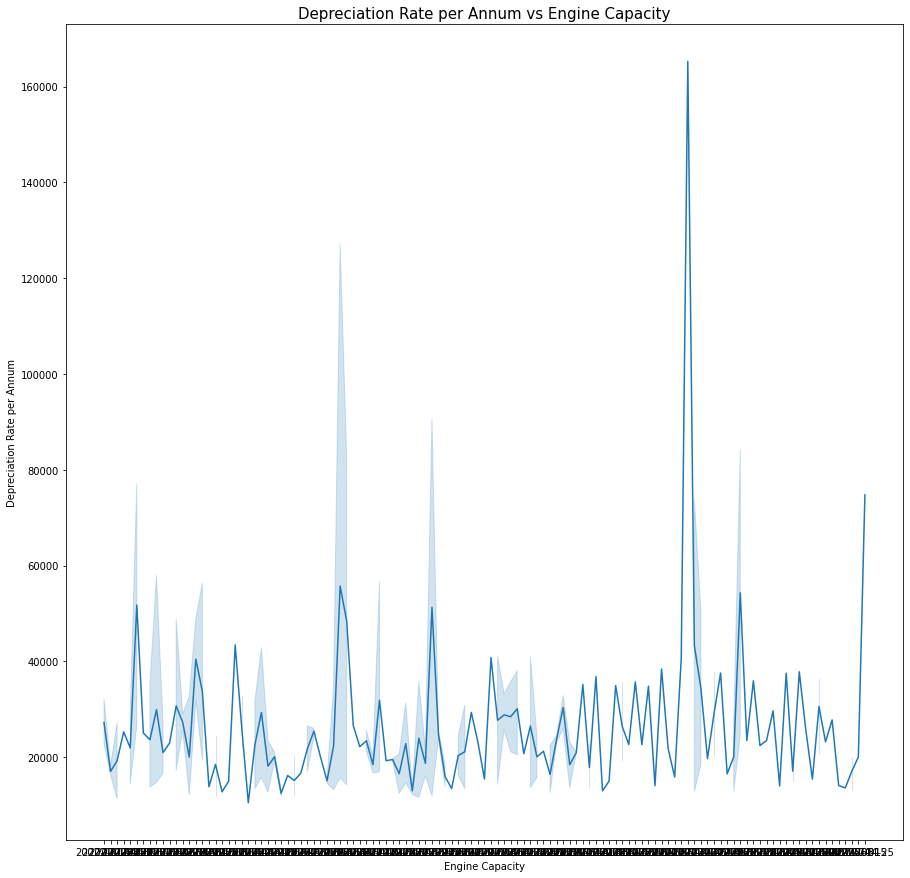

In [28]:
# 2. Relationship between brand and its selling price
# Draw relationship between car brand and selling price in the market
df3 = df[df["reg_date"] > "2022-00-00"] 
df3 = df3[df3["veh_type"] == "SUV"]
df3.head

plt.figure(figsize=(15,15))
sns.lineplot(data=df3, x="reg_date", y="depreciation")
plt.title("Depreciation Rate per Annum vs Engine Capacity", fontsize=15)
plt.xlabel("Engine Capacity", fontsize=10)
plt.ylabel("Depreciation Rate per Annum", fontsize=10)